In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import squeezenet1_0
from google.colab import drive
import os
from PIL import Image

drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install torchattack

In [15]:
from torchattack import PGD

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5); self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120); self.fc2 = nn.Linear(120, 84); self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)); x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x)); x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1); x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x)); return self.fc3(x)

class SqueezeNetMNIST(nn.Module):
    def __init__(self):
        super(SqueezeNetMNIST, self).__init__()
        self.model = squeezenet1_0(num_classes=10)
        self.model.classifier[1] = nn.Conv2d(512, 10, kernel_size=1)
    def forward(self, x):
        if x.shape[1] == 1: x = x.repeat(1, 3, 1, 1)
        return self.model(x)

model_configs = [
    ('Std LeNet', 'lenet.pth', 'lenet'),
    ('Std Squeeze', 'squeezenet.pth', 'squeezenet'),
    ('Rob LeNet', 'lenet_robust.pth', 'lenet'),
    ('Rob Squeeze', 'squeezenet_robust.pth', 'squeezenet')
]

In [17]:
base_path = '/content/drive/My Drive/adversarial_mnist'
adv_dir = f'{base_path}/large_adversarial_examples'
weights_dir = f'{base_path}/model_weights'
external_data_path = f'{base_path}/external_data/test/pgd'

zoo_models = {}
for name, fname, arch in model_configs:
    if arch == 'lenet':
        m = LeNet5()
    elif arch == 'squeezenet':
        m = SqueezeNetMNIST()
    else:
        m = SimpleCNN()

    path = f"{weights_dir}/{fname}"
    if os.path.exists(path):
        m.load_state_dict(torch.load(path, map_location=device))
        m.to(device).eval()
        zoo_models[name] = m
    else:
        print(f"Warning: Weights not found for {name}")

In [18]:
def load_external_dataset(folder_path):
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"External dataset not found at {folder_path}. Please check Drive setup.")

    print(f"Loading external adversarial data from {folder_path}...")

    transform = transforms.Compose([transforms.ToTensor()])

    mnist_test = datasets.MNIST(root='./data', train=False, download=True)
    labels = mnist_test.targets

    images = []
    filenames = sorted([f for f in os.listdir(folder_path) if f.endswith('.png') or f.endswith('.jpg')])

    limit = min(len(filenames), len(labels))

    for i in range(limit):
        img_path = os.path.join(folder_path, filenames[i])
        img = Image.open(img_path).convert('L')
        img_t = transform(img)
        images.append(img_t)

    print(f"Loaded {len(images)} external adversarial images.")
    return torch.stack(images), labels[:len(images)]

try:
    ext_imgs, ext_lbls = load_external_dataset(external_data_path)
except Exception as e:
    print(e)
    ext_imgs, ext_lbls = None, None

External dataset not found at /content/drive/My Drive/adversarial_mnist/external_data/test/pgd. Please check Drive setup.


In [19]:
def evaluate_dataset(model, imgs, lbls):
    if model is None or imgs is None: return 0
    with torch.no_grad():
        preds = model(imgs.to(device)).argmax(1)
        return (preds == lbls.to(device)).float().mean().item() * 100

clean_scores = []
whitebox_scores = []
zoo_defense_scores = []
blackbox_scores = []

matrix_acc = np.zeros((len(model_configs), len(model_configs)))

for i, (src_name, src_fname, _) in enumerate(model_configs):
    path = f"{adv_dir}/500_adv_{src_fname}"

    if not os.path.exists(path):
        clean_scores.append(0); whitebox_scores.append(0)
        continue

    data = torch.load(path)
    clean_scores.append(data.get('score_clean', 0))
    whitebox_scores.append(data.get('score_robust', 0))

    for j, (tgt_name, _, _) in enumerate(model_configs):
        if tgt_name in zoo_models:
            acc = evaluate_dataset(zoo_models[tgt_name], data['adv'], data['lbl'])
            matrix_acc[i, j] = acc

for j in range(len(model_configs)):
    other_scores = [matrix_acc[i, j] for i in range(len(model_configs)) if i != j]
    zoo_defense_scores.append(np.mean(other_scores) if other_scores else 0)

for name, _, _ in model_configs:
    if name in zoo_models and ext_imgs is not None:
        acc = evaluate_dataset(zoo_models[name], ext_imgs, ext_lbls)
        blackbox_scores.append(acc)
    else:
        blackbox_scores.append(0)

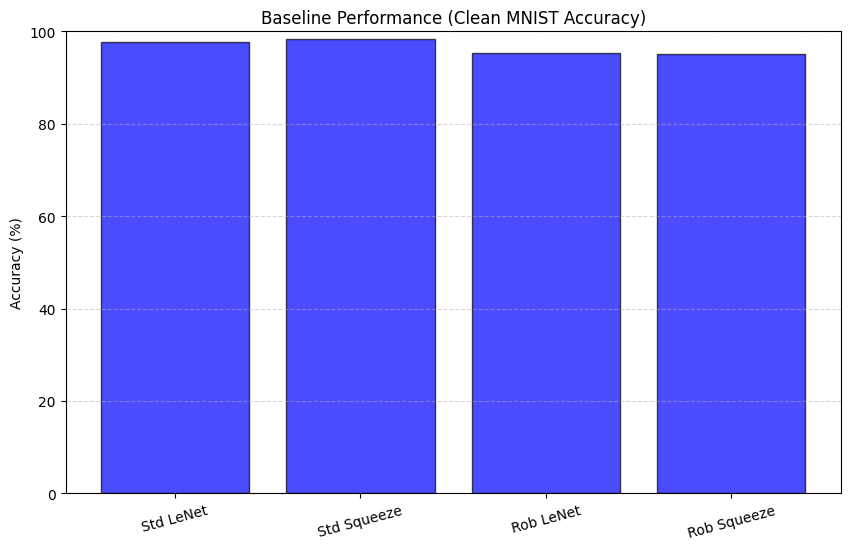

In [20]:
names = [c[0] for c in model_configs]
x = np.arange(len(names))

plt.figure(figsize=(10, 6))
plt.bar(x, clean_scores, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(x, names, rotation=15)
plt.ylabel("Accuracy (%)")
plt.title("Baseline Performance (Clean MNIST Accuracy)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

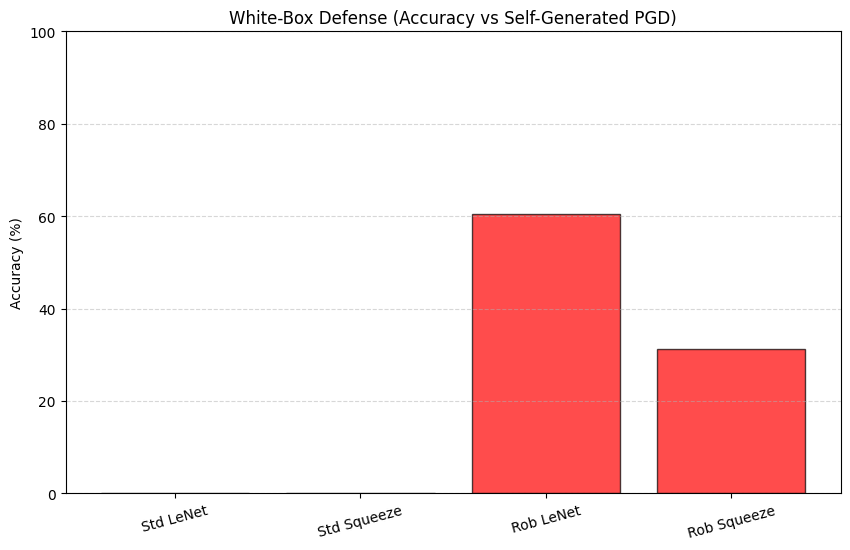

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(x, whitebox_scores, color='red', alpha=0.7, edgecolor='black')
plt.xticks(x, names, rotation=15)
plt.ylabel("Accuracy (%)")
plt.title("White-Box Defense (Accuracy vs Self-Generated PGD)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

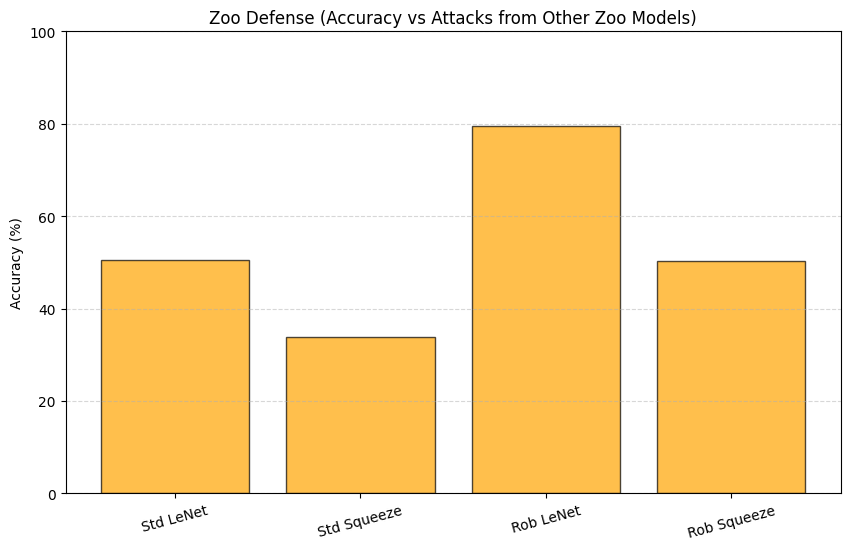

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(x, zoo_defense_scores, color='orange', alpha=0.7, edgecolor='black')
plt.xticks(x, names, rotation=15)
plt.ylabel("Accuracy (%)")
plt.title("Zoo Defense (Accuracy vs Attacks from Other Zoo Models)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

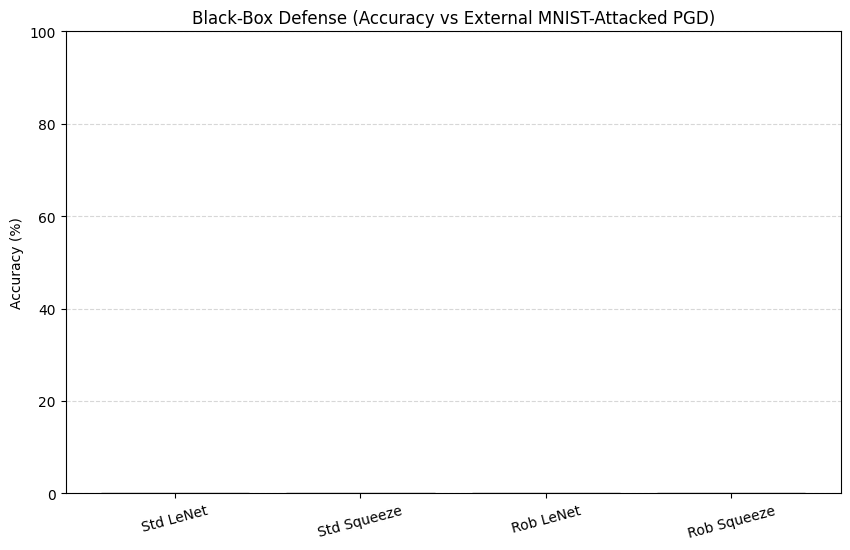

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(x, blackbox_scores, color='purple', alpha=0.7, edgecolor='black')
plt.xticks(x, names, rotation=15)
plt.ylabel("Accuracy (%)")
plt.title("Black-Box Defense (Accuracy vs External MNIST-Attacked PGD)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

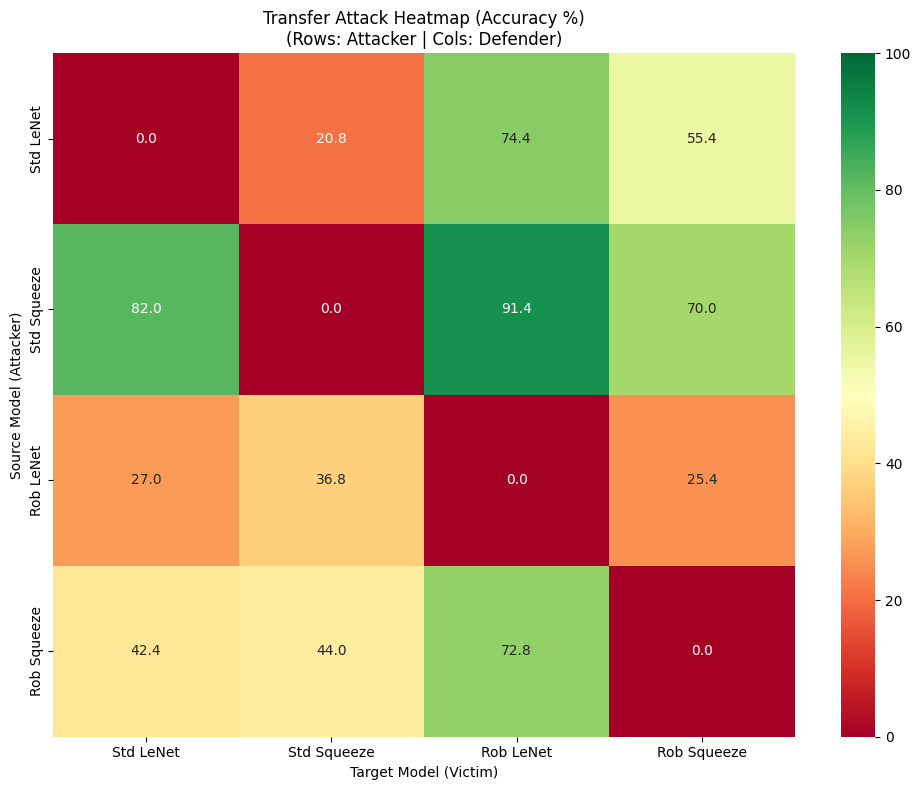

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix_acc, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
            xticklabels=names, yticklabels=names)
plt.title("Transfer Attack Heatmap (Accuracy %)\n(Rows: Attacker | Cols: Defender)")
plt.ylabel("Source Model (Attacker)")
plt.xlabel("Target Model (Victim)")
plt.tight_layout()
plt.show()